In [26]:
import keras
print keras.__version__

2.1.4


In [1]:
import pathlib2 
import imageio
import numpy as np
import pandas as pd

#training_paths = pathlib2.Path('FullTraining/').glob('*/images/*.png')
#training_sorted = sorted([x for x in training_paths])
#pick the 45th images
#im_path = training_sorted[45]
#read this iamges
#im = imageio.imread(str(im_path))


In [2]:
# Coerce the image into grayscale format (if not already)
#from skimage.color import rgb2gray

# Print the image dimensions
#print('Original image shape: {}'.format(im.shape))
#im_gray = rgb2gray(im)
#print('New image shape: {}'.format(im_gray.shape))
#print(im_gray)

#a=[]

#for i in range(len(training_sorted)):
    #pick the ith images
#    im_path = training_sorted[i]
    #read this images
#    im = imageio.imread(str(im_path))
#    im_gray = rgb2gray(im)
#    a.append(im_gray)
    
#print(a)    

### Convolutional Neural Network (CNN)

In [3]:
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('')
stage_label = 'stage1'

In [4]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
18884,a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a98...,"[263762, 3, 264364, 5, 264967, 6, 265570, 6, 2..."
20211,a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678...,"[31455, 2, 31973, 7, 32492, 9, 33011, 11, 3353..."
24771,d2815f2f616d92be35c7e8dcfe592deec88516aef9ffc9...,"[17784, 7, 18039, 10, 18294, 12, 18549, 14, 18..."


In [5]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
22021,stage1_train/8f27ebc74164eddfe989a98a754dcf5a9...,8f27ebc74164eddfe989a98a754dcf5a9c85ef599a1321...,masks,train,stage1
4090,stage1_train/b560dba92fbf2af785739efced50d5866...,b560dba92fbf2af785739efced50d5866c86dc4dada9be...,masks,train,stage1


In [6]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 46.5 s, sys: 9.15 s, total: 55.6 s
Wall time: 58.4 s


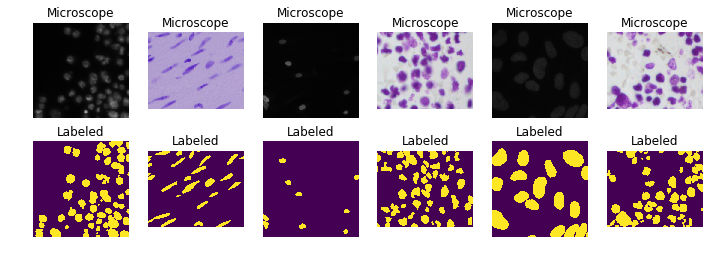

In [7]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [8]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]-x[:,:,2]))
#sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

In [9]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

In [42]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same', activation = 'relu'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same', activation = 'relu'))
# use dilations to get a slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same', activation = 'relu'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same', activation = 'relu'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same', activation = 'relu'))

# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'relu'))
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, None, 8)     224       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, None, None, 16)    528       
__________

In [43]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

In [44]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

simple_cnn.fit_generator(simple_gen(), 
                         steps_per_epoch=train_img_df.shape[0],
                        epochs = 3)

Epoch 1/3
670/670 [==============================] - 483s 721ms/step - loss: -1.7147 - dice_coef: 1.7147 - acc: 0.8261 - mean_squared_error: 1963.9178
Epoch 2/3
670/670 [==============================] - 484s 723ms/step - loss: -1.8670 - dice_coef: 1.8670 - acc: 0.8349 - mean_squared_error: 29857.5560
Epoch 3/3
670/670 [==============================] - 464s 692ms/step - loss: -1.9196 - dice_coef: 1.9196 - acc: 0.8562 - mean_squared_error: 48572.7293


In [45]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

(65, 'images to process')
CPU times: user 955 ms, sys: 300 ms, total: 1.25 s
Wall time: 1.3 s


In [46]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

CPU times: user 52.1 s, sys: 22.5 s, total: 1min 14s
Wall time: 18.2 s


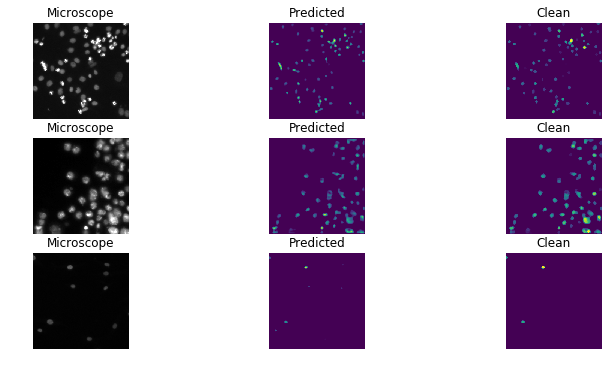

In [47]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

In [48]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [49]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

In [50]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

In [51]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


In [52]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [53]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

(1820, 'regions found for', 65, 'images')


,EncodedPixels,ImageId
1073,5011 4 5529 8 6048 9 6568 10 7087 11 7607 11 8...,78a981bd27ba0c65a9169548665a17bda9f49050d0d389...
68,2786 3 3040 7 3296 9 3551 10 3807 11 4063 11 4...,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...
1292,56 5 574 7 1092 8 1611 9 2129 10 2649 8 3168 8...,a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7b...


In [54]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)